#  How to create a fMRI analysis workflow


# 1st-level Analysis Workflow Structure

In this notebook, we will create a workflow that performs 1st-level analysis and normalizes the resulting beta weights to the MNI template. In concrete steps this means:

    1. Specify 1st-level model parameters
    2. Specify 1st-level contrasts
    3. Estimate 1st-level contrasts
    4. Normalize 1st-level contrasts

## Imports

In [1]:
import json, os, re
import pickle as pkl
import pandas as pd
import numpy as np
from scipy.io import loadmat
from nipype.interfaces.base import Bunch
from IPython.display import Image
import nibabel as nb
from nilearn.plotting import plot_anat, plot_glass_brain
from nilearn import plotting
from nipype import Node, Workflow, SelectFiles, JoinNode, MapNode, Function, IdentityInterface
from nipype.interfaces.io import DataSink
from nipype.interfaces.spm import Threshold
from nipype.interfaces.matlab import MatlabCommand
from nipype.algorithms.misc import Gunzip
from matplotlib import pyplot as plt
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Normalize12, OneSampleTTestDesign, EstimateModel, EstimateContrast
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


**Note:** Ideally you would also put the imports of all the interfaces that you use here at the top. But as we will develop the workflow step by step, we can also import the relevant modules as we go.

## Create Nodes

### Specify 1st-level model parameters (stimuli onsets, duration, etc.)

The specify the 1st-level model we need the subject-specific onset times and duration of the stimuli. Luckily, as we are working with a BIDS dataset, this information is nicely stored in a `tsv` file:

#### Rearrange data into Bunch (ignoring asking ans part)

In [2]:
def generate_three_list(task_condition_list, onset_list, duration_list):
    task_index_dict = dict()
    task_time_dict = dict()
    for task_type in set(task_condition_list):
        task_index_dict[task_type] = [i for i, j in enumerate(task_condition_list) if j==task_type]
        task_time_dict[task_type] = dict()
        task_time_dict[task_type]['onset'] = [onset_list[i] for i in task_index_dict[task_type]]
        task_time_dict[task_type]['duration'] = [duration_list[i] for i in task_index_dict[task_type]]
    task_condition_list = list(set(task_condition_list))
    onset_list = [task_time_dict[task]['onset'] for task in task_condition_list]
    duration_list = [task_time_dict[task]['duration'] for task in task_condition_list]
    return task_condition_list, onset_list, duration_list

In [3]:
bunchinfo = dict()     #for nipype
bunchinfo_ni = dict()  #for nitool
task_type_dict = {'Q':'Non','e':'Easy','d':'Diff'}
data_dir = '/home/neuro/Data/Visual_search_task/BIDS_data'
for sub in os.listdir(data_dir):
    bunchinfo_ni[sub] = dict()                             
    bunchinfo[sub] = dict()                 
    for session in ['session1', 'session2', 'session3', 'session4']:
        bunchinfo[sub][session] = None
        bunchinfo_ni[sub][session] = None
    csv_path = os.path.join(data_dir, sub, 'ses-test', 'func')
    csv_list = [candidate for candidate in os.listdir(csv_path) if re.search('.csv$', candidate)]
    for file_name in csv_list:
        sub_name = file_name.split('_')[0]
        session_name = file_name.split('_')[2].split('.')[0]
        trialinfo = pd.read_csv(os.path.join(csv_path, file_name))
        onset_list = []
        duration_list = []
        task_condition_list = []

        for ind, row in trialinfo.iterrows():
            task_condition = row['task state']
            if task_condition == 'start' or task_condition == 'asking ans': #跳过asking ans部分
                continue
            onset = trialinfo.iloc[ind-1]['date']
            duration = trialinfo.iloc[ind]['date'] - onset
            if task_condition == 'fix' or task_condition == 'asking MW':
                task_condition_list.append(task_condition)
            elif task_condition == 'blank':
                if trialinfo.iloc[ind-1]['task state'] == 'asking ans':
                    onset = trialinfo.iloc[ind-2]['date']
                    duration = trialinfo.iloc[ind]['date'] - onset
                    task_type = task_type_dict[trialinfo.iloc[ind-2]['task state'].split('.')[0][-1]]
                    task_condition = '-'.join([task_type, task_condition])
                    task_condition_list.append(task_condition)
                else:    
                    task_type = task_type_dict[trialinfo.iloc[ind-1]['task state'].split('.')[0][-1]]
                    task_condition = '-'.join([task_type, task_condition])
                    task_condition_list.append(task_condition)
            else:
                task_type = task_type_dict[trialinfo.iloc[ind]['task state'].split('.')[0][-1]]
                task_condition = '-'.join([task_type, 'task'])
                task_condition_list.append(task_condition)
            onset_list.append(float('%.1f'%onset))
            duration_list.append(float('%.1f'%duration))
        
        bunchinfo_ni[sub_name][session_name] = Bunch(conditions=task_condition_list, onsets=onset_list, durations=duration_list)
        task_condition_list, onset_list, duration_list = generate_three_list(task_condition_list, onset_list, duration_list)
        bunchinfo[sub_name][session_name] = Bunch(conditions=task_condition_list, onsets=onset_list, durations=duration_list)

# Writing 
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/ignore_bunch.pkl', 'wb') as f:
    pkl.dump(bunchinfo, f)
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/ignore_bunch_ni.pkl', 'wb') as f:
    pkl.dump(bunchinfo_ni, f)
# Reading
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/ignore_bunch.pkl', 'rb') as f:
    bunchinfo = pkl.load(f) 
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/ignore_bunch_ni.pkl', 'rb') as f:
    bunchinfo_ni = pkl.load(f) 

#### Rearrange data into Bunch (skipping asking ans partly)

In [31]:
bunchinfo = dict()
task_type_dict = {'Q':'Non','e':'Easy','d':'Diff'}
data_dir = '/home/neuro/Data/Visual_search_task/BIDS_data'
for sub in os.listdir(data_dir):
    bunchinfo[sub] = dict()
    for session in ['session1', 'session2', 'session3', 'session4']:
        bunchinfo[sub][session] = None
    csv_path = os.path.join(data_dir, sub, 'ses-test', 'func')
    csv_list = [candidate for candidate in os.listdir(csv_path) if re.search('.csv$', candidate)]
    for file_name in csv_list:
        sub_name = file_name.split('_')[0]
        session_name = file_name.split('_')[2].split('.')[0]
        trialinfo = pd.read_csv(os.path.join(csv_path, file_name))
        onset_list = []
        duration_list = []
        task_condition_list = []

        for ind, row in trialinfo.iterrows():
            task_condition = row['task state']
            if task_condition == 'start' or task_condition == 'asking ans': #跳过asking ans部分
                continue
            onset = trialinfo.iloc[ind-1]['date']
            duration = trialinfo.iloc[ind]['date'] - onset
            if task_condition == 'fix' or task_condition == 'asking MW':
                task_condition_list.append(task_condition)
            elif task_condition == 'blank':
                if trialinfo.iloc[ind-1]['task state'] == 'asking ans':
                    task_type = task_type_dict[trialinfo.iloc[ind-2]['task state'].split('.')[0][-1]]
                    task_condition = '-'.join([task_type, task_condition])
                    task_condition_list.append(task_condition)
                else:    
                    task_type = task_type_dict[trialinfo.iloc[ind-1]['task state'].split('.')[0][-1]]
                    task_condition = '-'.join([task_type, task_condition])
                    task_condition_list.append(task_condition)
            else:
                task_type = task_type_dict[trialinfo.iloc[ind]['task state'].split('.')[0][-1]]
                task_condition = '-'.join([task_type, 'task'])
                task_condition_list.append(task_condition)
            onset_list.append(onset)
            duration_list.append(duration)
        task_condition_list, onset_list, duration_list = generate_three_list(task_condition_list, onset_list, duration_list)
        bunchinfo[sub_name][session_name] = [Bunch(conditions=task_condition_list, onsets=onset_list, durations=duration_list)]  

# Writing 
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/skip_partly_bunch.pkl', 'wb') as f:
    pkl.dump(bunchinfo, f)
# Reading
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/skip_partly_bunch.pkl', 'rb') as f:
    bunchinfo = pkl.load(f) 

#### Rearrange data into Bunch (skipping asking ans totally)

In [32]:
bunchinfo = dict()
task_type_dict = {'Q':'Non','e':'Easy','d':'Diff'}
data_dir = '/home/neuro/Data/Visual_search_task/BIDS_data'
for sub in os.listdir(data_dir):
    bunchinfo[sub] = dict()
    for session in ['session1', 'session2', 'session3', 'session4']:
        bunchinfo[sub][session] = None
    csv_path = os.path.join(data_dir, sub, 'ses-test', 'func')
    csv_list = [candidate for candidate in os.listdir(csv_path) if re.search('.csv$', candidate)]
    for file_name in csv_list:
        sub_name = file_name.split('_')[0]
        session_name = file_name.split('_')[2].split('.')[0]
        trialinfo = pd.read_csv(os.path.join(csv_path, file_name))
        onset_list = []
        duration_list = []
        task_condition_list = []
        time_difference_list = []
        delete_row_list = []
        for ind, row in trialinfo.iterrows():
            if row['task state'] == 'asking ans':
                delete_row_list.extend([ind-2, ind-1, ind, ind+1, ind+2])
                time_difference_list.append(trialinfo.iloc[ind+2]['date'] - trialinfo.iloc[ind-3]['date'])

        skipcount = 0
        for ind, row in trialinfo.iterrows():
            task_condition = row['task state']
            if task_condition == 'start': 
                continue
            if ind in delete_row_list:
                skipcount += 1
                continue
            onset = trialinfo.iloc[ind-1]['date'] - sum(time_difference_list[:skipcount//5]) 
            duration = trialinfo.iloc[ind]['date'] - onset - sum(time_difference_list[:skipcount//5]) 
            if task_condition == 'fix' or task_condition == 'asking MW':
                task_condition_list.append(task_condition)
            elif task_condition == 'blank':
                task_type = task_type_dict[trialinfo.iloc[ind-1]['task state'].split('.')[0][-1]]
                task_condition = '-'.join([task_type, task_condition])
                task_condition_list.append(task_condition)
            else:
                task_type = task_type_dict[trialinfo.iloc[ind]['task state'].split('.')[0][-1]]
                task_condition = '-'.join([task_type, 'task'])
                task_condition_list.append(task_condition)
            onset_list.append(onset)
            duration_list.append(duration)
        task_condition_list, onset_list, duration_list = generate_three_list(task_condition_list, onset_list, duration_list)
        bunchinfo[sub_name][session_name] = [Bunch(conditions=task_condition_list, onsets=onset_list, durations=duration_list)]  

# Writing 
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/skip_totally_bunch.pkl', 'wb') as f:
    pkl.dump(bunchinfo, f)
# Reading
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/skip_totally_bunch.pkl', 'rb') as f:
    bunchinfo = pkl.load(f) 

#### Rearrange data into Bunch (label asking ans part simply)

In [33]:
bunchinfo = dict()
task_type_dict = {'Q':'Non','e':'Easy','d':'Diff'}
data_dir = '/home/neuro/Data/Visual_search_task/BIDS_data'
for sub in os.listdir(data_dir):
    bunchinfo[sub] = dict()
    for session in ['session1', 'session2', 'session3', 'session4']:
        bunchinfo[sub][session] = None
    csv_path = os.path.join(data_dir, sub, 'ses-test', 'func')
    csv_list = [candidate for candidate in os.listdir(csv_path) if re.search('.csv$', candidate)]
    for file_name in csv_list:
        sub_name = file_name.split('_')[0]
        session_name = file_name.split('_')[2].split('.')[0]
        trialinfo = pd.read_csv(os.path.join(csv_path, file_name))
        onset_list = []
        duration_list = []
        task_condition_list = []

        for ind, row in trialinfo.iterrows():
            task_condition = row['task state']
            if task_condition == 'start': 
                continue
            onset = trialinfo.iloc[ind-1]['date']
            duration = trialinfo.iloc[ind]['date'] - onset
            if task_condition == 'fix' or task_condition == 'asking MW' or task_condition == 'asking ans':
                task_condition_list.append(task_condition)
            elif task_condition == 'blank':
                if trialinfo.iloc[ind-1]['task state'] == 'asking ans':
                    task_type = task_type_dict[trialinfo.iloc[ind-2]['task state'].split('.')[0][-1]]
                    task_condition = '-'.join([task_type, task_condition])
                    task_condition_list.append(task_condition)
                else:    
                    task_type = task_type_dict[trialinfo.iloc[ind-1]['task state'].split('.')[0][-1]]
                    task_condition = '-'.join([task_type, task_condition])
                    task_condition_list.append(task_condition)
            else:
                task_type = task_type_dict[trialinfo.iloc[ind]['task state'].split('.')[0][-1]]
                task_condition = '-'.join([task_type, 'task'])
                task_condition_list.append(task_condition)
            onset_list.append(onset)
            duration_list.append(duration)
        task_condition_list, onset_list, duration_list = generate_three_list(task_condition_list, onset_list, duration_list)
        bunchinfo[sub_name][session_name] = [Bunch(conditions=task_condition_list, onsets=onset_list, durations=duration_list)]  

# Writing 
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/label_simply_bunch.pkl', 'wb') as f:
    pkl.dump(bunchinfo, f)
# Reading
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/label_simply_bunch.pkl', 'rb') as f:
    bunchinfo = pkl.load(f) 

#### Rearrange data into Bunch (label asking ans detailedly)

In [34]:
bunchinfo = dict()
task_type_dict = {'Q':'Non','e':'Easy','d':'Diff'}
data_dir = '/home/neuro/Data/Visual_search_task/BIDS_data'
for sub in os.listdir(data_dir):
    bunchinfo[sub] = dict()
    for session in ['session1', 'session2', 'session3', 'session4']:
        bunchinfo[sub][session] = None
    csv_path = os.path.join(data_dir, sub, 'ses-test', 'func')
    csv_list = [candidate for candidate in os.listdir(csv_path) if re.search('.csv$', candidate)]
    for file_name in csv_list:
        sub_name = file_name.split('_')[0]
        session_name = file_name.split('_')[2].split('.')[0]
        trialinfo = pd.read_csv(os.path.join(csv_path, file_name))
        onset_list = []
        duration_list = []
        task_condition_list = []

        for ind, row in trialinfo.iterrows():
            task_condition = row['task state']
            if task_condition == 'start': #跳过asking ans部分
                continue
            onset = trialinfo.iloc[ind-1]['date']
            duration = trialinfo.iloc[ind]['date'] - onset
            if task_condition == 'fix' or task_condition == 'asking MW':
                task_condition_list.append(task_condition)
            elif task_condition == 'blank':
                if trialinfo.iloc[ind-1]['task state'] == 'asking ans':
                    task_type = task_type_dict[trialinfo.iloc[ind-2]['task state'].split('.')[0][-1]]
                    task_condition = '-'.join([task_type, task_condition])
                    task_condition_list.append(task_condition)
                else:    
                    task_type = task_type_dict[trialinfo.iloc[ind-1]['task state'].split('.')[0][-1]]
                    task_condition = '-'.join([task_type, task_condition])
                    task_condition_list.append(task_condition)
            elif task_condition == 'asking ans':
                task_type = task_type_dict[trialinfo.iloc[ind-1]['task state'].split('.')[0][-1]]
                task_condition = '-'.join([task_type, 'ans'])
                task_condition_list.append(task_condition)                
            else:
                task_type = task_type_dict[trialinfo.iloc[ind]['task state'].split('.')[0][-1]]
                task_condition = '-'.join([task_type, 'task'])
                task_condition_list.append(task_condition)
            onset_list.append(onset)
            duration_list.append(duration)
        task_condition_list, onset_list, duration_list = generate_three_list(task_condition_list, onset_list, duration_list)
        bunchinfo[sub_name][session_name] = [Bunch(conditions=task_condition_list, onsets=onset_list, durations=duration_list)]  

# Writing 
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/label_detailedly_bunch.pkl', 'wb') as f:
    pkl.dump(bunchinfo, f)
# Reading
with open('/home/neuro/Result/Visual_search_task/1st_analysis/bunch/label_detailedly_bunch.pkl', 'rb') as f:
    bunchinfo = pkl.load(f) 

### Create Bunch object and workflow and GLM model

To create a GLM model, Nipype needs an list of `Bunch` objects per session. As we only have one session, our object needs to look as follows:

    [Bunch(conditions=['Finger', 'Foot', 'Lips'],
           durations=[[15.0, 15.0, 15.0, 15.0, 15.0],
                      [15.0, 15.0, 15.0, 15.0, 15.0],
                      [15.0, 15.0, 15.0, 15.0, 15.0]],
           onsets=[[10, 100, 190, 280, 370],
                   [40, 130, 220, 310, 400],
                   [70, 160, 250, 340, 430]]
           )]

Good! Now we can create the node that will create the SPM model. For this we will be using `SpecifySPMModel`. As a reminder the TR of the acquisition is 2s and we want to use a high pass filter of 128.

In [5]:
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=2,
                                 high_pass_filter_cutoff=128), name="modelspec")

This node will also need some additional inputs, such as the preprocessed functional images, the motion parameters etc. We will specify those once we take care of the workflow data input stream.

### Specify 1st-level contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. 

In [6]:
# Condition names
condition_names = ['fix', 'asking MW', 'Easy-task', 'Diff-task', 'Non-task', 'Easy-blank', 'Diff-blank', 'Non-blank']

# Contrasts
cont01 = ['Non-task > Diff-task',        'T', condition_names, [0, 0, 0, -1, 1, 0, 0, 0]]
cont02 = ['Diff-task > Non-task',        'T', condition_names, [0, 0, 0, 1, -1, 0, 0, 0]]
cont03 = ['Easy-task > Non-task',        'T', condition_names, [0, 0, 1, 0, -1, 0, 0, 0]]
cont04 = ['Easy-task > Diff-task',       'T', condition_names, [0, 0, 1, -1, 0, 0, 0, 0]]
cont05 = ['Diff-task > Easy-task',       'T', condition_names, [0, 0, -1, 1, 0, 0, 0, 0]]
cont06 = ['Non-blank > Diff-blank',      'T', condition_names, [0, 0, 0, 0, 0, 0, -1, 1]]
cont07 = ['Diff-blank > Non-blank',      'T', condition_names, [0, 0, 0, 0, 0, 0, 1, -1]]
cont08 = ['Non-blank > Easy-blank',      'T', condition_names, [0, 0, 0, 0, 0, -1, 0, 1]]
cont09 = ['Easy-blank > Diff-blank',     'T', condition_names, [0, 0, 0, 0, 0, 1, -1, 0]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

### Estimate 1st-level contrasts

Before we can estimate the 1st-level contrasts, we first need to create the 1st-level design. Here you can also specify what kind of basis function you want (HRF, FIR, Fourier, etc.), if you want to use time and dispersion derivatives and how you want to model the serial correlation.In this example, I propose that you use an HRF basis function, that we model time derivatives and that we model the serial correlation with AR(1).

In [7]:
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=2,
                                 model_serial_correlations='AR(1)'), name="level1design")

stty: 'standard input': Inappropriate ioctl for device


Now we need to estimate the model. I recommend that you'll use a `Classical: 1` method to estimate the model.

In [8]:
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}), name="level1estimate")

Now that we estimate the model, we can estimate the contrasts. Don't forget to feed the list of contrast we specify above to this node.

In [9]:
level1conest = Node(EstimateContrast(contrasts=contrast_list), name="level1conest")

### Normalize 1st-level contrasts

Now that the contrasts were estimated in subject space we can put them into a common reference space by normalizing them to a specific template. In this case, we will be using SPM12's Normalize routine and normalize to the SPM12 tissue probability map `TPM.nii`. At this step, you can also specify the voxel resolution of the output volumes. If you don't specify it, it will normalize to a voxel resolution of 2x2x2mm. As a training exercise, set the voxel resolution to 4x4x4mm.

In [10]:
template = '/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[4, 4, 4]), name="normalize")

### Gunzip Node

In [11]:
gunzip_func = Node(Gunzip(),  name='gunzip_func')

### Self-made node for selecting subject bunch

In [12]:
def bunch_extract(file_path, subj_id):
    subject = 'sub-'+subj_id
    import pickle as pkl
    with open(file_path, 'rb') as f:
        bunchinfo = pkl.load(f) 
    bunch_list = []
    for bunch in bunchinfo[subject].values():
        bunch_list.append(bunch)
    return bunch_list

bunch_extract_node = Node(Function(input_names=['file_path', 'subj_id'], output_names=['bunch_list'], function=bunch_extract), 
                          name='bunch_extract_node')
bunch_extract_node.inputs.file_path = '/home/neuro/Result/Visual_search_task/1st_analysis/bunch/ignore_bunch.pkl'

## Datainput with `SelectFiles` and `iterables` 


In [13]:
subj_id_list = ['%02d'%i for i in range(1, 23)]
subj_id_node = Node(IdentityInterface(fields=['subj_id']), name='subj_id_node')
subj_id_node.iterables = [('subj_id', subj_id_list)]

In [14]:
templates_anat = {'anat': '/home/neuro/Data/Visual_search_task/BIDS_data/sub-{subj_id}/ses-test/anat/sub-{subj_id}_ses-test_anat_sT1W.nii'}
selectanat = Node(SelectFiles(templates_anat, sort_filelist=True), name='selectanat')

In [15]:
session_id_list = ['1', '2', '3', '4']
templates_func = {'func': '/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc_result/func/_subject_id_{subj_id}_task_number_{session_id}/detrend.nii.gz', 
                  'mc_param': '/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc_result/par/_subject_id_{subj_id}_task_number_{session_id}/sub-{subj_id}_ses-test_session{session_id}_bold_mcf.par',
                  'outliers': '/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc_result/outlier_files/_subject_id_{subj_id}_task_number_{session_id}/art.sub-{subj_id}_ses-test_session{session_id}_bold_mcf_outliers.txt'}
selectfunc = Node(SelectFiles(templates_func, sort_filelist=True), name='selectfunc')
selectfunc.iterables = [('session_id', session_id_list)]

### Three integration function

In [16]:
def func_image_integration(func_image):
    return func_image
func_inte_node = JoinNode(Function(input_names=['func_image'], output_names=['func_image_list'], function= func_image_integration), 
                          joinsource= selectfunc,
                          joinfield= ['func_image'],
                          name='func_inte_node')

In [17]:
def realignment_parameter_integration(realignment_parameter):
    return realignment_parameter
real_inte_node = JoinNode(Function(input_names=['realignment_parameter'], output_names=['realignment_parameter_list'], function= realignment_parameter_integration), 
                          joinsource= selectfunc,
                          joinfield= ['realignment_parameter'],
                          name='real_inte_node')

In [18]:
def outlier_file_integration(outlier_file):
    return outlier_file
outlier_inte_node = JoinNode(Function(input_names=['outlier_file'], output_names=['outlier_file_list'], function= outlier_file_integration), 
                          joinsource= selectfunc,
                          joinfield= ['outlier_file'],
                          name='outlier_inte_node')

And as a final step, we just need to connect this `SelectFiles` node to the rest of the workflow.

## Data output with `DataSink`

Now, before we run the workflow, let's again specify a `Datasink` folder to only keep those files that we want to keep.

In [19]:
datasink = Node(DataSink(base_directory='/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result',
                         container='datasink'), name="datasink")
substitutions = [('_subj_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

Now the next step is to specify all the output that we want to keep in our output folder `output`. Probably best to keep are the:
- SPM.mat file and the spmT and spmF files from the contrast estimation node
- normalized betas and anatomy

In [20]:
analysis1st = Workflow(name='work_1st', base_dir='/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result')
analysis1st.connect([(subj_id_node, bunch_extract_node, [('subj_id', 'subj_id')]),
                     (subj_id_node, selectanat, [('subj_id', 'subj_id')]),
                     (subj_id_node, selectfunc, [('subj_id', 'subj_id')]),
                     (selectanat, normalize, [('anat', 'image_to_align')]), 
                     (selectfunc, gunzip_func, [('func', 'in_file')]), 
                     (gunzip_func, func_inte_node, [('out_file', 'func_image')]),
                     (func_inte_node, modelspec, [(('func_image_list'), 'functional_runs')]),
                     (selectfunc, outlier_inte_node, [('outliers', 'outlier_file')]),
                     (outlier_inte_node, modelspec, [(('outlier_file_list'), 'outlier_files')]),
                     (selectfunc, real_inte_node, [('mc_param', 'realignment_parameter')]),
                     (real_inte_node, modelspec, [(('realignment_parameter_list'), 'realignment_parameters')]),
                     (bunch_extract_node, modelspec, [('bunch_list', 'subject_info')]), 
                     (modelspec, level1design, [('session_info', 'session_info')]), 
                     (level1design, level1estimate, [('spm_mat_file', 'spm_mat_file')]), 
                     (level1estimate, level1conest, [('spm_mat_file', 'spm_mat_file'),
                                                     ('beta_images', 'beta_images'),
                                                     ('residual_image', 'residual_image')]), 
                     (level1conest, normalize, [('con_images','apply_to_files')])
                     ])
analysis1st.connect([(level1conest, datasink, [('con_images', '1stLevel.@con'),
                                               ('spm_mat_file', '1stLevel.@spm_mat'),
                                               ('spmT_images', '1stLevel.@T')]),
                     (normalize, datasink, [('normalized_files', 'normalized.@files'),
                                            ('normalized_image', 'normalized.@image')])
                    ])

## Visualize the workflow

Now that the workflow is finished, let's visualize it again.

In [21]:
# Create 1st-level analysis output graph
analysis1st.write_graph(graph2use='exec', format='png', simple_form=True)

211118-10:02:54,216 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/graph.png (graph2use=exec, simple_form=True).


'/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/graph.png'

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [22]:
analysis1st.run('MultiProc', plugin_args={'n_procs': 4})

211118-10:03:51,146 nipype.workflow INFO:
	 Workflow work_1st settings: ['check', 'execution', 'logging', 'monitoring']
211118-10:03:52,77 nipype.workflow INFO:
	 Running in parallel.
211118-10:03:52,89 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 132 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211118-10:03:52,227 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfunc" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_22/_session_id_4/selectfunc".
211118-10:03:52,235 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfunc" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_22/_session_id_3/selectfunc".
211118-10:03:52,243 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfunc" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_22/_session_id_2/selectfunc".
211118-10:03:52,254 nipype.workflow INFO:
	 [Node] Setting-up 

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_20/modelspec/art.sub-20_ses-test_session1_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211118-10:04:20,939 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".
211118-10:04:22,113 nipype.workflow INFO:
	 [Job 51] Completed (work_1st.modelspec).
211118-10:04:22,116 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 114 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1design
211118-10:04:22,290 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:04:22,313 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1design" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_20/level1design".
211118-10:04:22,315 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:04:22,317 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfunc" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/wor

stty: 'standard input': Inappropriate ioctl for device


211118-10:04:56,143 nipype.workflow INFO:
	 [Job 14] Completed (work_1st.level1design).
211118-10:04:56,147 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1design
                       * work_1st.level1design
211118-10:04:56,471 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:04:56,474 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_22/level1estimate".
211118-10:04:56,477 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:04:57,758 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:04:58,144 nipype.workflow INFO:
	 [MultiProc] Runn

stty: 'standard input': Inappropriate ioctl for device


211118-10:05:24,165 nipype.workflow INFO:
	 [Job 33] Completed (work_1st.level1design).
211118-10:05:24,167 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1design
                       * work_1st.level1design
211118-10:05:24,949 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:05:24,952 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_21/level1estimate".
211118-10:05:24,955 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:05:26,167 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 108 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 0/4.
                     Currently run

stty: 'standard input': Inappropriate ioctl for device


211118-10:05:42,957 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:05:42,960 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_20/level1estimate".
211118-10:05:42,963 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:05:44,88 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:05:44,185 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 108 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 0/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.level1design
211118-10:05:50,689 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1design".


stty: 'standard input': Inappropriate ioctl for device


211118-10:05:52,189 nipype.workflow INFO:
	 [Job 71] Completed (work_1st.level1design).
211118-10:05:52,192 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:05:52,386 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:05:52,390 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_19/level1estimate".
211118-10:05:52,394 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:05:53,403 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:05:54,191 nipype.workflow INFO:
	 [MultiProc

stty: 'standard input': Inappropriate ioctl for device


211118-10:05:59,456 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:06:00,196 nipype.workflow INFO:
	 [Job 15] Completed (work_1st.level1estimate).
211118-10:06:00,199 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:06:00,328 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:06:00,340 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_22/level1conest".
211118-10:06:00,344 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:06:02,198 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 108 jobs ready. Fr

stty: 'standard input': Inappropriate ioctl for device


211118-10:06:15,760 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:06:16,209 nipype.workflow INFO:
	 [Job 16] Completed (work_1st.level1conest).
211118-10:06:16,212 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:06:16,301 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:06:16,304 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_22/normalize".
211118-10:06:16,307 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:06:16,881 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Norma

stty: 'standard input': Inappropriate ioctl for device


211118-10:06:27,518 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:06:28,221 nipype.workflow INFO:
	 [Job 34] Completed (work_1st.level1estimate).
211118-10:06:28,223 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:06:28,379 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:06:28,388 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_21/level1conest".
211118-10:06:28,391 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:06:30,223 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 108 jobs ready. Free me

stty: 'standard input': Inappropriate ioctl for device


211118-10:06:43,824 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:06:44,231 nipype.workflow INFO:
	 [Job 35] Completed (work_1st.level1conest).
211118-10:06:44,233 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:06:44,347 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:06:44,351 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_21/normalize".
211118-10:06:44,354 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:06:45,550 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize1

stty: 'standard input': Inappropriate ioctl for device


211118-10:06:46,233 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 108 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 0/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:06:46,266 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:06:48,234 nipype.workflow INFO:
	 [Job 53] Completed (work_1st.level1estimate).
211118-10:06:48,237 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.level1estimate
211118-10:06:48,364 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:06:48,376 nipype.

stty: 'standard input': Inappropriate ioctl for device


211118-10:06:56,77 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:06:56,241 nipype.workflow INFO:
	 [Job 72] Completed (work_1st.level1estimate).
211118-10:06:56,243 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:06:56,387 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:06:56,397 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_19/level1conest".
211118-10:06:56,400 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:06:58,244 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 108 jobs ready. Free memory (GB

stty: 'standard input': Inappropriate ioctl for device


211118-10:07:03,530 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:07:04,247 nipype.workflow INFO:
	 [Job 54] Completed (work_1st.level1conest).
211118-10:07:04,249 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:07:04,363 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:07:04,366 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_20/normalize".
211118-10:07:04,369 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:07:04,872 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211

stty: 'standard input': Inappropriate ioctl for device


211118-10:07:11,696 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:07:12,252 nipype.workflow INFO:
	 [Job 73] Completed (work_1st.level1conest).
211118-10:07:12,254 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:07:12,367 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:07:12,370 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_19/normalize".
211118-10:07:12,372 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:07:12,882 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211118

stty: 'standard input': Inappropriate ioctl for device


211118-10:08:28,324 nipype.workflow INFO:
	 [Job 17] Completed (work_1st.normalize).
211118-10:08:28,326 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 109 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:08:28,424 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:08:28,426 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_22/datasink".
211118-10:08:28,429 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:08:28,507 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:08:28,509 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_resu

stty: 'standard input': Inappropriate ioctl for device


211118-10:08:56,736 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
211118-10:08:57,240 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".
211118-10:08:58,349 nipype.workflow INFO:
	 [Job 36] Completed (work_1st.normalize).
211118-10:08:58,350 nipype.workflow INFO:
	 [Job 89] Completed (work_1st.modelspec).
211118-10:08:58,352 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 104 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:08:58,473 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:08:58,475 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_21/datasink".
211118-10:08:58,478 nipype.workflow INFO:
	 [Node] Outdated cache found fo

stty: 'standard input': Inappropriate ioctl for device


211118-10:09:16,361 nipype.workflow INFO:
	 [Job 55] Completed (work_1st.normalize).
211118-10:09:16,363 nipype.workflow INFO:
	 [Job 101] Completed (work_1st.selectfunc).
211118-10:09:16,366 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 102 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
211118-10:09:16,459 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:09:16,462 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_20/datasink".
211118-10:09:16,464 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:09:16,483 nipype.workflow INFO:
	 [Job 102] Cached (work_1st.real_inte_node).
211118-10:09:16,537 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.inter

stty: 'standard input': Inappropriate ioctl for device


211118-10:09:20,363 nipype.workflow INFO:
	 [Job 74] Completed (work_1st.normalize).
211118-10:09:20,366 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 100 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * work_1st.level1design
211118-10:09:20,470 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:09:20,473 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_19/datasink".
211118-10:09:20,476 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:09:20,543 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:09:20,545 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/normalized/_subj_id_19/wcon_0001.nii -> /home/neuro/Result/Visual_search_

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_17/modelspec/art.sub-17_ses-test_session1_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211118-10:09:25,574 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".
211118-10:09:26,368 nipype.workflow INFO:
	 [Job 75] Completed (work_1st.datasink).
211118-10:09:26,369 nipype.workflow INFO:
	 [Job 108] Completed (work_1st.modelspec).
211118-10:09:26,371 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 96 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * work_1st.level1design
211118-10:09:26,604 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:09:26,631 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1design" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_17/level1design".
211118-10:09:26,632 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfunc" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_16/_session_id_3/selectfunc".
211118-10:09:26,634

stty: 'standard input': Inappropriate ioctl for device


211118-10:09:42,378 nipype.workflow INFO:
	 [Job 90] Completed (work_1st.level1design).
211118-10:09:42,379 nipype.workflow INFO:
	 [Job 135] Completed (work_1st.selectfunc).
211118-10:09:42,382 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 90 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1design
211118-10:09:42,571 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:09:42,573 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_18/level1estimate".
211118-10:09:42,577 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:09:42,586 nipype.workflow INFO:
	 [Job 136] Cached (work_1st.gunzip_func).
211118-10:09:43,231 nipype.workflow INFO:
	 [Node] Running

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_15/modelspec/art.sub-15_ses-test_session3_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211118-10:10:03,418 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".
211118-10:10:04,394 nipype.workflow INFO:
	 [Job 146] Completed (work_1st.modelspec).
211118-10:10:04,396 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1design
                       * work_1st.level1design
211118-10:10:04,599 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:10:04,619 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1design" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_15/level1design".
211118-10:10:04,622 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:10:04,860 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level

stty: 'standard input': Inappropriate ioctl for device


211118-10:10:08,398 nipype.workflow INFO:
	 [Job 109] Completed (work_1st.level1design).
211118-10:10:08,401 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1estimate
                       * work_1st.level1design
211118-10:10:08,656 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:10:08,658 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_17/level1estimate".
211118-10:10:08,662 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:10:09,590 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:10:10,400 nipype.workflow INFO:
	 [MultiProc] Ru

stty: 'standard input': Inappropriate ioctl for device


211118-10:10:22,406 nipype.workflow INFO:
	 [Job 128] Completed (work_1st.level1design).
211118-10:10:22,408 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1design
                       * work_1st.level1estimate
211118-10:10:22,629 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:10:22,632 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_16/level1estimate".
211118-10:10:22,635 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:10:23,353 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:10:24,408 nipype.workflow INFO:
	 [MultiProc] 

stty: 'standard input': Inappropriate ioctl for device


211118-10:10:45,896 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1design".
211118-10:10:45,968 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".


stty: 'standard input': Inappropriate ioctl for device


211118-10:10:46,428 nipype.workflow INFO:
	 [Job 91] Completed (work_1st.level1estimate).
211118-10:10:46,429 nipype.workflow INFO:
	 [Job 147] Completed (work_1st.level1design).
211118-10:10:46,432 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 86 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:10:46,553 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:10:46,562 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_18/level1conest".
211118-10:10:46,565 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:10:46,663 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:10:46,665 nipype.workflow INFO

stty: 'standard input': Inappropriate ioctl for device


211118-10:11:02,258 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:11:02,442 nipype.workflow INFO:
	 [Job 92] Completed (work_1st.level1conest).
211118-10:11:02,444 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:11:02,560 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:11:02,564 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_18/normalize".
211118-10:11:02,566 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:11:03,199 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normal

stty: 'standard input': Inappropriate ioctl for device


211118-10:11:11,429 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:11:12,452 nipype.workflow INFO:
	 [Job 110] Completed (work_1st.level1estimate).
211118-10:11:12,454 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1estimate
                       * work_1st.level1estimate
211118-10:11:12,745 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:11:12,755 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_17/level1conest".
211118-10:11:12,758 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:11:14,454 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 84 jobs ready. Free mem

stty: 'standard input': Inappropriate ioctl for device


211118-10:11:26,196 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:11:26,462 nipype.workflow INFO:
	 [Job 129] Completed (work_1st.level1estimate).
211118-10:11:26,465 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.normalize
                       * work_1st.level1estimate
211118-10:11:26,578 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:11:26,587 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_16/level1conest".
211118-10:11:26,590 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".


stty: 'standard input': Inappropriate ioctl for device


211118-10:11:27,908 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:11:28,464 nipype.workflow INFO:
	 [Job 111] Completed (work_1st.level1conest).
211118-10:11:28,467 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.normalize
                       * work_1st.level1estimate
211118-10:11:28,491 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211118-10:11:28,572 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:11:28,575 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_17/normalize".
211118-10:11:28,577 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normali

stty: 'standard input': Inappropriate ioctl for device


211118-10:11:41,476 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:11:42,478 nipype.workflow INFO:
	 [Job 130] Completed (work_1st.level1conest).
211118-10:11:42,480 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.level1estimate
211118-10:11:42,584 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:11:42,587 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_16/normalize".
211118-10:11:42,590 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:11:43,91 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
21

stty: 'standard input': Inappropriate ioctl for device


211118-10:11:49,182 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:11:50,483 nipype.workflow INFO:
	 [Job 148] Completed (work_1st.level1estimate).
211118-10:11:50,486 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:11:50,693 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:11:50,702 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_15/level1conest".
211118-10:11:50,705 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:11:52,343 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.Estima

stty: 'standard input': Inappropriate ioctl for device


211118-10:12:05,197 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:12:06,495 nipype.workflow INFO:
	 [Job 149] Completed (work_1st.level1conest).
211118-10:12:06,497 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:12:06,627 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:12:06,632 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_15/normalize".
211118-10:12:06,635 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:12:07,138 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211118

stty: 'standard input': Inappropriate ioctl for device


211118-10:13:20,563 nipype.workflow INFO:
	 [Job 93] Completed (work_1st.normalize).
211118-10:13:20,565 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 85 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:13:20,653 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:13:20,655 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_18/datasink".
211118-10:13:20,658 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:13:20,721 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:13:20,722 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_resul

stty: 'standard input': Inappropriate ioctl for device


211118-10:13:38,579 nipype.workflow INFO:
	 [Job 112] Completed (work_1st.normalize).
211118-10:13:38,581 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 83 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:13:38,671 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:13:38,674 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_17/datasink".
211118-10:13:38,677 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:13:38,692 nipype.workflow INFO:
	 [Job 160] Cached (work_1st.outlier_inte_node).
211118-10:13:38,742 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:13:38,744 nipype.interface INFO:
	 sub: /home/neuro/Resul

stty: 'standard input': Inappropriate ioctl for device


211118-10:14:28,623 nipype.workflow INFO:
	 [Job 166] Completed (work_1st.level1design).
211118-10:14:28,626 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 73 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:14:28,811 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:14:28,814 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_14/level1estimate".
211118-10:14:28,817 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:14:29,443 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:14:30,625 nipype.workflow INFO:
	 [MultiProc] Running 4 

stty: 'standard input': Inappropriate ioctl for device


211118-10:14:52,642 nipype.workflow INFO:
	 [Job 185] Completed (work_1st.level1design).
211118-10:14:52,645 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 73 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:14:52,864 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:14:52,867 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_13/level1estimate".
211118-10:14:52,870 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:14:53,512 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:14:54,643 nipype.workflow INFO:
	 [MultiProc] Running 

stty: 'standard input': Inappropriate ioctl for device


211118-10:14:56,645 nipype.workflow INFO:
	 [Job 131] Completed (work_1st.normalize).
211118-10:14:56,647 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 73 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:14:56,776 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:14:56,779 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_16/datasink".
211118-10:14:56,782 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:14:56,849 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:14:56,851 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/ana

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_12/modelspec/art.sub-12_ses-test_session2_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_12/modelspec/art.sub-12_ses-test_session3_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211118-10:15:25,520 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".
211118-10:15:26,671 nipype.workflow INFO:
	 [Job 203] Completed (work_1st.modelspec).
211118-10:15:26,674 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 67 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:15:26,840 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:15:26,855 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1design" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_12/level1design".
211118-10:15:26,858 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:15:27,167 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1

stty: 'standard input': Inappropriate ioctl for device


211118-10:15:28,673 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 66 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 0/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:15:28,992 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:15:30,673 nipype.workflow INFO:
	 [Job 167] Completed (work_1st.level1estimate).
211118-10:15:30,675 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 67 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:15:30,773 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:15:30,782 ni

stty: 'standard input': Inappropriate ioctl for device


211118-10:15:42,685 nipype.workflow INFO:
	 [Job 150] Completed (work_1st.normalize).
211118-10:15:42,687 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 67 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.level1design
                       * work_1st.level1estimate
211118-10:15:42,777 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:15:42,780 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_15/datasink".
211118-10:15:42,783 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:15:42,852 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:15:42,854 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/an

stty: 'standard input': Inappropriate ioctl for device


211118-10:15:44,890 nipype.workflow INFO:
	 [Node] Running "selectfunc" ("nipype.interfaces.io.SelectFiles")
211118-10:15:44,967 nipype.workflow INFO:
	 [Node] Finished "work_1st.selectfunc".
211118-10:15:45,538 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:15:46,688 nipype.workflow INFO:
	 [Job 168] Completed (work_1st.level1conest).
211118-10:15:46,689 nipype.workflow INFO:
	 [Job 209] Completed (work_1st.selectfunc).
211118-10:15:46,692 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 67 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1estimate
211118-10:15:46,831 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:15:46,835 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj

stty: 'standard input': Inappropriate ioctl for device


211118-10:15:54,100 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:15:54,694 nipype.workflow INFO:
	 [Job 186] Completed (work_1st.level1estimate).
211118-10:15:54,697 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 65 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.gunzip_func
                       * work_1st.normalize
                       * work_1st.level1design
211118-10:15:54,916 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:15:54,926 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_13/level1conest".
211118-10:15:54,929 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:15:55,559 nipype.workflow INFO:
	 [Node] Finished "work_1st.gunzip_func".
211118-10:15:56,696 n

stty: 'standard input': Inappropriate ioctl for device


211118-10:16:10,709 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 62 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 0/4.
                     Currently running:
                       * work_1st.gunzip_func
                       * work_1st.level1conest
                       * work_1st.normalize
                       * work_1st.level1design
211118-10:16:11,81 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:16:11,931 nipype.workflow INFO:
	 [Node] Finished "work_1st.gunzip_func".
211118-10:16:12,710 nipype.workflow INFO:
	 [Job 187] Completed (work_1st.level1conest).
211118-10:16:12,711 nipype.workflow INFO:
	 [Job 218] Completed (work_1st.gunzip_func).
211118-10:16:12,714 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 64 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1design
211118-10:

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_11/modelspec/art.sub-11_ses-test_session3_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211118-10:16:19,382 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".
211118-10:16:20,718 nipype.workflow INFO:
	 [Job 222] Completed (work_1st.modelspec).
211118-10:16:20,720 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 61 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.level1design
211118-10:16:20,894 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:16:20,910 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1design" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_11/level1design".
211118-10:16:20,913 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:16:20,925 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1design".


stty: 'standard input': Inappropriate ioctl for device


211118-10:16:21,120 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211118-10:16:22,719 nipype.workflow INFO:
	 [Job 204] Completed (work_1st.level1design).
211118-10:16:22,721 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 61 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:16:22,905 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:16:22,908 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_12/level1estimate".
211118-10:16:22,910 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:16:23,468 nipype.workflow INFO:
	 [Node] Running "level1est

stty: 'standard input': Inappropriate ioctl for device


211118-10:16:54,752 nipype.workflow INFO:
	 [Job 223] Completed (work_1st.level1design).
211118-10:16:54,754 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 61 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:16:54,879 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_11/level1estimate".
211118-10:16:55,55 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:16:56,754 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 60 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 0/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.lev

stty: 'standard input': Inappropriate ioctl for device


211118-10:17:06,766 nipype.workflow ERROR:
	 Node level1estimate.b10 failed to run on host 9a23e6b9473d.
211118-10:17:06,767 nipype.workflow ERROR:
	 Saving crash info to /work/crash-20211118-101706-neuro-level1estimate.b10-9c0808b3-a9e6-476e-b606-d57b014823a9.pklz
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/spm/base.py", line 387, in _run_interface
    resu

stty: 'standard input': Inappropriate ioctl for device


211118-10:17:24,780 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 57 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:17:24,883 nipype.workflow INFO:
	 [Job 237] Cached (work_1st.gunzip_func).
211118-10:17:24,944 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:17:26,781 nipype.workflow INFO:
	 [Job 205] Completed (work_1st.level1estimate).
211118-10:17:26,783 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 58 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:17:26,889 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:17:26,898 nipype.workflow INFO:

stty: 'standard input': Inappropriate ioctl for device


211118-10:17:41,113 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:17:42,793 nipype.workflow INFO:
	 [Job 206] Completed (work_1st.level1conest).
211118-10:17:42,796 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 55 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:17:42,899 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:17:42,902 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_12/normalize".
211118-10:17:42,905 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:17:43,465 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211

stty: 'standard input': Inappropriate ioctl for device


211118-10:17:46,796 nipype.workflow INFO:
	 [Job 169] Completed (work_1st.normalize).
211118-10:17:46,799 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 55 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1design
                       * work_1st.normalize
211118-10:17:46,896 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:17:46,899 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_14/datasink".
211118-10:17:46,901 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:17:46,967 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:17:46,969 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_r

stty: 'standard input': Inappropriate ioctl for device


211118-10:18:16,817 nipype.workflow INFO:
	 [Job 242] Completed (work_1st.level1design).
211118-10:18:16,819 nipype.workflow INFO:
	 [Job 259] Completed (work_1st.bunch_extract_node).
211118-10:18:16,820 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 50 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:18:16,997 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:18:16,999 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_10/level1estimate".
211118-10:18:17,2 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:18:17,83 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.modelspec".
211118-10:18:17,87 nipype.workflow INFO:
	 [N

stty: 'standard input': Inappropriate ioctl for device


211118-10:18:18,818 nipype.workflow INFO:
	 [Job 188] Completed (work_1st.normalize).
211118-10:18:18,820 nipype.workflow INFO:
	 [Job 260] Completed (work_1st.modelspec).
211118-10:18:18,822 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 50 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:18:18,933 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:18:18,935 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_13/datasink".
211118-10:18:18,938 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:18:19,4 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:18:19,5 nipype.interface INFO:
	 sub: /home/neuro/Result/Vi

stty: 'standard input': Inappropriate ioctl for device


211118-10:18:58,852 nipype.workflow INFO:
	 [Job 261] Completed (work_1st.level1design).
211118-10:18:58,855 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 43 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:18:59,69 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:18:59,72 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_09/level1estimate".
211118-10:18:59,75 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:18:59,743 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:19:00,853 nipype.workflow INFO:
	 [MultiProc] Running 

stty: 'standard input': Inappropriate ioctl for device


211118-10:19:17,412 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:19:18,863 nipype.workflow INFO:
	 [Job 243] Completed (work_1st.level1estimate).
211118-10:19:18,865 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 43 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1design
                       * work_1st.normalize
211118-10:19:19,6 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:19:19,15 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_10/level1conest".
211118-10:19:19,18 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:19:20,780 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.Es

stty: 'standard input': Inappropriate ioctl for device


211118-10:19:33,550 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1design".


stty: 'standard input': Inappropriate ioctl for device


211118-10:19:33,895 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:19:34,876 nipype.workflow INFO:
	 [Job 280] Completed (work_1st.level1design).
211118-10:19:34,877 nipype.workflow INFO:
	 [Job 244] Completed (work_1st.level1conest).
211118-10:19:34,879 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 44 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:19:34,973 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:19:34,976 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_10/normalize".
211118-10:19:34,979 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:19:35,73 nipype.workflow INFO:
	 [Node] Outdated cache found for "

stty: 'standard input': Inappropriate ioctl for device


211118-10:19:48,886 nipype.workflow INFO:
	 [Job 207] Completed (work_1st.normalize).
211118-10:19:48,888 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 43 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
                       * work_1st.level1estimate
211118-10:19:48,990 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:19:48,993 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_12/datasink".
211118-10:19:48,997 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:19:49,65 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:19:49,67 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analy

stty: 'standard input': Inappropriate ioctl for device


211118-10:20:01,61 nipype.workflow INFO:
	 [Node] Running "selectfunc" ("nipype.interfaces.io.SelectFiles")
211118-10:20:01,102 nipype.workflow INFO:
	 [Node] Finished "work_1st.selectfunc".
211118-10:20:01,386 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:20:02,898 nipype.workflow INFO:
	 [Job 262] Completed (work_1st.level1estimate).
211118-10:20:02,899 nipype.workflow INFO:
	 [Job 289] Completed (work_1st.selectfunc).
211118-10:20:02,901 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 41 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:20:03,354 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:20:03,365 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st

stty: 'standard input': Inappropriate ioctl for device


211118-10:20:17,948 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:20:18,909 nipype.workflow INFO:
	 [Job 263] Completed (work_1st.level1conest).
211118-10:20:18,911 nipype.workflow INFO:
	 [Job 297] Completed (work_1st.bunch_extract_node).
211118-10:20:18,913 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 38 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:20:19,24 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:20:19,27 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_09/normalize".
211118-10:20:19,30 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:20:19,122 nipype.workflow INFO:
	 [Node] Outdated cache found f

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_07/modelspec/art.sub-07_ses-test_session2_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211118-10:20:19,846 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211118-10:20:19,876 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".
211118-10:20:20,910 nipype.workflow INFO:
	 [Job 298] Completed (work_1st.modelspec).
211118-10:20:20,912 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 37 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:20:21,136 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:20:21,157 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1design" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_07/level1design".
211118-10:20:21,160 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1desi

stty: 'standard input': Inappropriate ioctl for device


211118-10:20:34,974 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:20:36,926 nipype.workflow INFO:
	 [Job 281] Completed (work_1st.level1estimate).
211118-10:20:36,929 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 37 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:20:37,47 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:20:37,56 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_08/level1conest".
211118-10:20:37,58 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:20:38,565 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.Estima

stty: 'standard input': Inappropriate ioctl for device


211118-10:20:51,604 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:20:52,939 nipype.workflow INFO:
	 [Job 282] Completed (work_1st.level1conest).
211118-10:20:52,941 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 37 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:20:53,71 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:20:53,75 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_08/normalize".
211118-10:20:53,77 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:20:54,724 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211118

stty: 'standard input': Inappropriate ioctl for device


211118-10:21:01,137 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:21:01,139 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_07/level1estimate".
211118-10:21:01,142 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:21:01,911 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:21:02,948 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 36 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 0/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:21:51,538 nipype.workflow INFO:
	 [Node] Finished "work_1st.normalize".


stty: 'standard input': Inappropriate ioctl for device


211118-10:21:52,992 nipype.workflow INFO:
	 [Job 245] Completed (work_1st.normalize).
211118-10:21:52,995 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 37 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:21:53,95 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:21:53,98 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_10/datasink".
211118-10:21:53,100 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:21:53,165 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:21:53,167 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_r

stty: 'standard input': Inappropriate ioctl for device


211118-10:22:05,91 nipype.workflow INFO:
	 [Job 309] Cached (work_1st.gunzip_func).
211118-10:22:05,456 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:22:07,3 nipype.workflow INFO:
	 [Job 300] Completed (work_1st.level1estimate).
211118-10:22:07,5 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 34 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:22:07,318 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:22:07,327 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_07/level1conest".
211118-10:22:07,330 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:22:07,335 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.se

stty: 'standard input': Inappropriate ioctl for device


211118-10:22:21,15 nipype.workflow INFO:
	 [Job 316] Completed (work_1st.bunch_extract_node).
211118-10:22:21,19 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 31 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:22:21,199 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.modelspec".
211118-10:22:21,203 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.modelspec" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_06/modelspec".
211118-10:22:21,207 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.modelspec".
211118-10:22:21,443 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
211118-10:22:21,674 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
2

stty: 'standard input': Inappropriate ioctl for device


211118-10:22:25,18 nipype.workflow INFO:
	 [Job 264] Completed (work_1st.normalize).
211118-10:22:25,21 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 31 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:22:25,118 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:22:25,121 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_09/datasink".
211118-10:22:25,124 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:22:25,188 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:22:25,190 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_res

stty: 'standard input': Inappropriate ioctl for device


211118-10:22:53,42 nipype.workflow INFO:
	 [Job 283] Completed (work_1st.normalize).
211118-10:22:53,44 nipype.workflow INFO:
	 [Job 335] Completed (work_1st.bunch_extract_node).
211118-10:22:53,46 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 26 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
211118-10:22:53,163 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:22:53,166 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_08/datasink".
211118-10:22:53,169 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:22:53,229 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:22:53,231 nipype.interface INFO:
	 sub: /home/neuro/R

stty: 'standard input': Inappropriate ioctl for device


211118-10:23:07,51 nipype.workflow INFO:
	 [Job 318] Completed (work_1st.level1design).
211118-10:23:07,54 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 23 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
211118-10:23:07,258 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:23:07,260 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_06/level1estimate".
211118-10:23:07,263 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:23:07,271 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfunc" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_04/_session_id_2/selectfunc".
211118-10:23:07,343 nipype.work

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_04/modelspec/art.sub-04_ses-test_session4_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211118-10:23:25,896 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".
211118-10:23:27,63 nipype.workflow INFO:
	 [Job 355] Completed (work_1st.modelspec).
211118-10:23:27,65 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 19 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1design
                       * work_1st.normalize
211118-10:23:27,275 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:23:27,293 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1design" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_04/level1design".
211118-10:23:27,297 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:23:27,543 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Desi

stty: 'standard input': Inappropriate ioctl for device


211118-10:23:33,68 nipype.workflow INFO:
	 [Job 337] Completed (work_1st.level1design).
211118-10:23:33,71 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 19 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:23:33,433 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:23:33,435 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_05/level1estimate".
211118-10:23:33,438 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:23:34,36 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:23:35,69 nipype.workflow INFO:
	 [MultiProc] Running 4

stty: 'standard input': Inappropriate ioctl for device


211118-10:24:07,95 nipype.workflow INFO:
	 [Job 356] Completed (work_1st.level1design).
211118-10:24:07,98 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 19 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:24:07,315 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:24:07,318 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_04/level1estimate".
211118-10:24:07,322 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:24:07,979 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")


stty: 'standard input': Inappropriate ioctl for device


211118-10:24:09,20 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:24:09,96 nipype.workflow INFO:
	 [Job 319] Completed (work_1st.level1estimate).
211118-10:24:09,98 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 19 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:24:09,209 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:24:09,217 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_06/level1conest".
211118-10:24:09,220 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:24:10,837 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model

stty: 'standard input': Inappropriate ioctl for device


211118-10:24:24,38 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:24:25,109 nipype.workflow INFO:
	 [Job 320] Completed (work_1st.level1conest).
211118-10:24:25,112 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 19 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:24:25,559 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:24:25,562 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_06/normalize".
211118-10:24:25,564 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:24:26,104 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12

stty: 'standard input': Inappropriate ioctl for device


211118-10:24:35,57 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:24:35,118 nipype.workflow INFO:
	 [Job 338] Completed (work_1st.level1estimate).
211118-10:24:35,121 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 19 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:24:35,316 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:24:35,326 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_05/level1conest".
211118-10:24:35,330 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:24:37,41 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.Est

stty: 'standard input': Inappropriate ioctl for device


211118-10:24:49,746 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:24:50,881 nipype.workflow INFO:
	 [Node] Finished "work_1st.normalize".


stty: 'standard input': Inappropriate ioctl for device


211118-10:24:51,131 nipype.workflow INFO:
	 [Job 302] Completed (work_1st.normalize).
211118-10:24:51,133 nipype.workflow INFO:
	 [Job 339] Completed (work_1st.level1conest).
211118-10:24:51,135 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 20 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1estimate
211118-10:24:51,273 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:24:51,275 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_07/datasink".
211118-10:24:51,278 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:24:51,304 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:24:51,308 nipype.workflow INFO:
	 [Node] Setting-up "work_1s

stty: 'standard input': Inappropriate ioctl for device


211118-10:25:07,876 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:25:09,143 nipype.workflow INFO:
	 [Job 357] Completed (work_1st.level1estimate).
211118-10:25:09,145 nipype.workflow INFO:
	 [Job 367] Completed (work_1st.selectfunc).
211118-10:25:09,147 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 18 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:25:09,273 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:25:09,282 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_04/level1conest".
211118-10:25:09,286 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:25:09,301 nipype.workflow INFO:
	 [Job 368] Cached (work_

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_03/modelspec/art.sub-03_ses-test_session1_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_03/modelspec/art.sub-03_ses-test_session2_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_03/modelspec/art.sub-03_ses-test_session4_bold_mcf_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211118-10:25:21,873 nipype.workflow INFO:
	 [Node] Finished "work_1st.modelspec".


stty: 'standard input': Inappropriate ioctl for device


211118-10:25:23,149 nipype.workflow INFO:
	 [Job 374] Completed (work_1st.modelspec).
211118-10:25:23,152 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 13 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:25:23,354 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:25:23,367 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1design" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_03/level1design".
211118-10:25:23,370 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1design".
211118-10:25:23,558 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211118-10:25:23,654 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1cone

stty: 'standard input': Inappropriate ioctl for device


211118-10:26:03,185 nipype.workflow INFO:
	 [Job 375] Completed (work_1st.level1design).
211118-10:26:03,187 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 13 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:26:03,379 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:26:03,381 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_03/level1estimate".
211118-10:26:03,384 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:26:03,916 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:26:05,187 nipype.workflow INFO:
	 [MultiProc] Running 4 tas

stty: 'standard input': Inappropriate ioctl for device


211118-10:26:35,212 nipype.workflow INFO:
	 [Job 321] Completed (work_1st.normalize).
211118-10:26:35,214 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 13 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:26:35,326 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:26:35,330 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_06/datasink".
211118-10:26:35,334 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:26:35,409 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:26:35,410 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis

stty: 'standard input': Inappropriate ioctl for device


211118-10:27:05,84 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:27:05,237 nipype.workflow INFO:
	 [Job 376] Completed (work_1st.level1estimate).
211118-10:27:05,238 nipype.workflow INFO:
	 [Job 393] Completed (work_1st.modelspec).
211118-10:27:05,240 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 8 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:27:05,392 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:27:05,401 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_03/level1conest".
211118-10:27:05,404 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:27:05,549 nipype.workflow INFO:
	 [Node] Outdated cache foun

stty: 'standard input': Inappropriate ioctl for device


211118-10:27:20,109 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:27:21,252 nipype.workflow INFO:
	 [Job 377] Completed (work_1st.level1conest).
211118-10:27:21,254 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:27:21,399 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:27:21,403 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_03/normalize".
211118-10:27:21,406 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:27:21,946 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
2111

stty: 'standard input': Inappropriate ioctl for device


211118-10:27:35,265 nipype.workflow INFO:
	 [Job 340] Completed (work_1st.normalize).
211118-10:27:35,268 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1design
                       * work_1st.normalize
211118-10:27:35,390 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:27:35,394 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_05/datasink".
211118-10:27:35,396 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:27:35,485 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:27:35,487 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_re

stty: 'standard input': Inappropriate ioctl for device


211118-10:27:47,275 nipype.workflow INFO:
	 [Job 394] Completed (work_1st.level1design).
211118-10:27:47,277 nipype.workflow INFO:
	 [Job 401] Completed (work_1st.selectfunc).
211118-10:27:47,280 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.normalize
211118-10:27:47,468 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:27:47,471 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_02/level1estimate".
211118-10:27:47,473 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:27:47,487 nipype.workflow INFO:
	 [Job 402] Cached (work_1st.gunzip_func).
211118-10:27:48,104 nipype.workflow INFO:
	 [Node] Running "leve

stty: 'standard input': Inappropriate ioctl for device


211118-10:28:13,294 nipype.workflow INFO:
	 [Job 359] Completed (work_1st.normalize).
211118-10:28:13,296 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * work_1st.level1design
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:28:13,409 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:28:13,411 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_04/datasink".
211118-10:28:13,414 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:28:13,475 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:28:13,477 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analys

stty: 'standard input': Inappropriate ioctl for device


211118-10:28:47,321 nipype.workflow INFO:
	 [Job 413] Completed (work_1st.level1design).
211118-10:28:47,324 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:28:47,549 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:28:47,552 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1estimate" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_01/level1estimate".
211118-10:28:47,555 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1estimate".
211118-10:28:48,210 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211118-10:28:49,322 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 0 jobs ready. Free memory (GB): 

stty: 'standard input': Inappropriate ioctl for device


211118-10:28:50,126 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:28:51,323 nipype.workflow INFO:
	 [Job 395] Completed (work_1st.level1estimate).
211118-10:28:51,325 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:28:51,457 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:28:51,472 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_02/level1conest".
211118-10:28:51,475 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:28:53,318 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211118-10:28:53,326 nipype.

stty: 'standard input': Inappropriate ioctl for device


211118-10:29:06,526 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:29:07,338 nipype.workflow INFO:
	 [Job 396] Completed (work_1st.level1conest).
211118-10:29:07,340 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.level1estimate
                       * work_1st.normalize
211118-10:29:07,518 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:29:07,521 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_02/normalize".
211118-10:29:07,524 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:29:08,62 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211118-10:29:09,341 nipype.workflow INFO:
	 [Mu

stty: 'standard input': Inappropriate ioctl for device


211118-10:29:21,349 nipype.workflow INFO:
	 [Job 378] Completed (work_1st.normalize).
211118-10:29:21,352 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * work_1st.normalize
                       * work_1st.level1estimate
211118-10:29:21,452 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:29:21,454 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_03/datasink".
211118-10:29:21,457 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:29:21,521 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:29:21,523 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/normalized/_subj_id_03/wcon_

stty: 'standard input': Inappropriate ioctl for device


211118-10:29:48,851 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1estimate".
211118-10:29:49,372 nipype.workflow INFO:
	 [Job 414] Completed (work_1st.level1estimate).
211118-10:29:49,374 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * work_1st.normalize
211118-10:29:49,506 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:29:49,516 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_01/level1conest".
211118-10:29:49,519 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
211118-10:29:51,278 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211118-10:29:51,375 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and

stty: 'standard input': Inappropriate ioctl for device


211118-10:30:03,408 nipype.workflow INFO:
	 [Node] Finished "work_1st.level1conest".
211118-10:30:05,387 nipype.workflow INFO:
	 [Job 415] Completed (work_1st.level1conest).
211118-10:30:05,389 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * work_1st.normalize
211118-10:30:05,485 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:30:05,489 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_01/normalize".
211118-10:30:05,492 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.normalize".
211118-10:30:05,969 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211118-10:30:07,390 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free

stty: 'standard input': Inappropriate ioctl for device


211118-10:31:09,449 nipype.workflow INFO:
	 [Job 397] Completed (work_1st.normalize).
211118-10:31:09,451 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * work_1st.normalize
211118-10:31:09,556 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:31:09,559 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_02/datasink".
211118-10:31:09,562 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:31:09,625 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:31:09,627 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/normalized/_subj_id_02/wcon_0001.nii -> /home/neuro/Result/Visual_search_task

stty: 'standard input': Inappropriate ioctl for device


211118-10:31:53,496 nipype.workflow INFO:
	 [Job 416] Completed (work_1st.normalize).
211118-10:31:53,504 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211118-10:31:53,607 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:31:53,610 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/work_1st/_subj_id_01/datasink".
211118-10:31:53,613 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.datasink".
211118-10:31:53,677 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-10:31:53,679 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/normalized/_subj_id_01/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/normalized/sub-01/wcon_0001.nii
211118-10:31:

RuntimeError: Workflow did not execute cleanly. Check log for details

## Visualize results

First, let's look at the 1st-level Design Matrix of subject one, to verify that everything is as it should be.

In [126]:
# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/1stLevel/sub-01/SPM.mat',
                 struct_as_record=False)

The design matrix and the names of the regressors are a bit hidden in the `spmmat` variable, but they can be accessed as follows:

In [137]:
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

Now before we can plot it, we just need to normalize the desing matrix in such a way, that each column has a maximum amplitude of 1. This is just for visualization purposes, otherwise the rotation parameters with their rather small values will not show up in the figure.

In [141]:
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

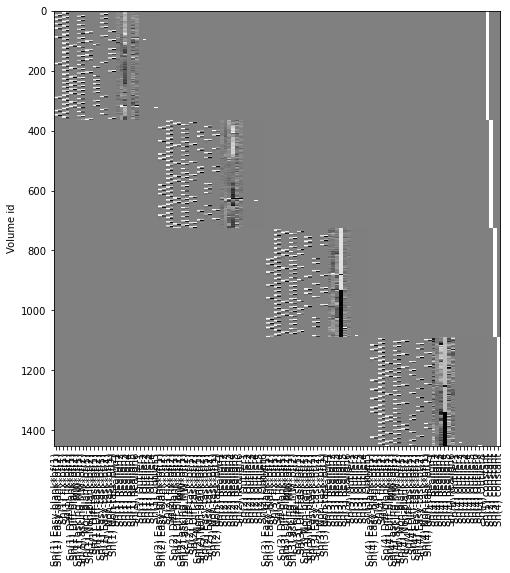

In [142]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90)

Now that we're happy with the design matrix, let's look how well the normalization worked.

/tmp/ipykernel_23901/3961184609.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  GM_template = nb.Nifti1Image(img.get_data()[..., 0], img.affine, img.header)


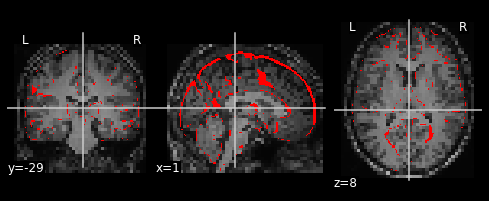

In [167]:
# Load GM probability map of TPM.nii
img = nb.load('/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii')
GM_template = nb.Nifti1Image(img.get_data()[..., 0], img.affine, img.header)

# Plot normalized subject anatomy
display = plot_anat('/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/normalized/sub-01/wsub-01_ses-test_anat_sT1W.nii',
                    dim=-0.3)

# Overlay in edges GM map
display.add_edges(GM_template)

Let's look at the contrasts of one subject that we've just computed. In particular the F-contrast.

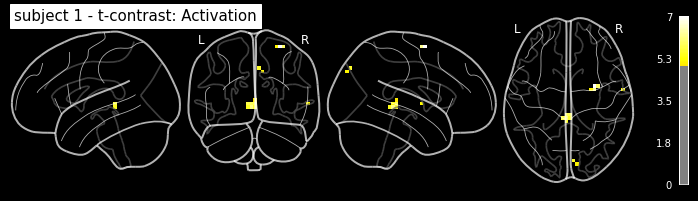

In [171]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/normalized/sub-01/wcon_0002.nii',
                 colorbar=True, display_mode='lyrz', black_bg=True, threshold=5,
                 title='subject 1 - t-contrast: Activation')

# 2nd-level Analysis Workflow Structure

Last but not least, the group level analysis. This example will also directly include thresholding of the output, as well as some visualization.

## Create Nodes and Workflow connections

### Workflow for the 2nd-level analysis

## 2nd-Level Design

This step depends on your study design and the tests you want to perform. If you're using SPM to do the group analysis, you have the liberty to choose between a factorial design, a multiple regression design, one-sample T-Test design, a paired T-Test design or a two-sample T-Test design.

For the current example, we will be using a one sample T-Test design. Now we just need to specify this binary mask as an `explicit_mask_file` for the one sample T-test node.

In [174]:
onesamplettestdes = Node(OneSampleTTestDesign(), name="onesampttestdes")
onesamplettestdes.inputs.explicit_mask_file = '/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc_result/GM_mask.nii'

The next two steps are the same as for the 1st-level design, i.e. estimation of the model followed by estimation of the contrasts.

In [176]:
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

To finish the `EstimateContrast` node, we also need to specify which contrast should be computed. For a 2nd-level one sample t-test design, this is rather straightforward:

In [177]:
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont01 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont01]

Now, let's connect those three design nodes to each other.

## Thresholding of output contrast

And to close, we will use SPM `Threshold`. With this routine, we can set a specific voxel threshold (i.e. *p*<0.001) and apply an FDR cluster threshold (i.e. *p*<0.05). As we only have 5 subjects, I recommend to set the voxel threshold to 0.01 and to leave the cluster threshold at 0.05.

In [182]:
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.01,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05), name="level2thresh")

## Gray Matter Mask

We could run our 2nd-level workflow as it is. All the major nodes are there. But I nonetheless suggest that we use a gray matter mask to restrict the analysis to only gray matter voxels.

In the 1st-level analysis, we normalized to SPM12's `TPM.nii` tissue probability atlas. Therefore, we could just take the gray matter probability map of this `TPM.nii` image (the first volume) and threshold it at a certain probability value to get a binary mask. 

Let's take a look at this mask:

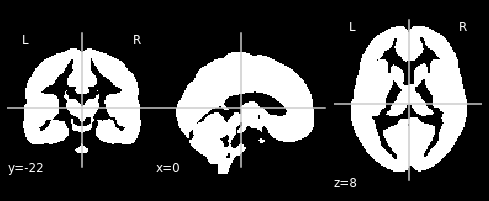

In [184]:
plot_anat('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc_result/GM_mask.nii', dim=-1)

## Datainput with `SelectFiles` and `iterables` 

We will again be using [`SelectFiles`](../../../nipype_tutorial/notebooks/basic_data_input.ipynb#SelectFiles) and [`iterables`](../../../nipype_tutorial/notebooks/basic_iteration.ipynb).


In [187]:
# String template with {}-based strings
templates = {'cons': '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/datasink/normalized/sub-*/w*_{cont_id}.nii'}
selectfiles_2nd = Node(SelectFiles(templates, sort_filelist=True), name='selectfiles')
contrast_id_list = ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']
selectfiles_2nd.iterables = [('cont_id', contrast_id_list)]

Now we need to connect the `SelectFiles` to the `OneSampleTTestDesign` node.

## Data output with `DataSink`

Now, before we run the workflow, let's again specify a `Datasink` folder to only keep those files that we want to keep.

In [191]:
# Initiate the datasink node
datasink_2nd = Node(DataSink(base_directory='/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result',
                         container='datasink'), name="datasink_2nd")
substitutions = [('_cont_id_', 'con_')]
datasink.inputs.substitutions = substitutions

Now the next step is to specify all the output that we want to keep in our output folder `output`. Probably best to keep are the:
- the SPM.mat file and the spmT images from the `EstimateContrast` node
- the thresholded spmT images from the `Threshold` node

In [197]:
analysis2nd = Workflow(name='analysis_result', base_dir='/home/neuro/Result/Visual_search_task/2nd_analysis')
analysis2nd.connect([(selectfiles_2nd, onesamplettestdes, [('cons', 'in_files')]),
                     (onesamplettestdes, level2estimate, [('spm_mat_file', 'spm_mat_file')]),
                     (level2estimate, level2conestimate, [('spm_mat_file', 'spm_mat_file'),
                                                          ('beta_images', 'beta_images'),
                                                          ('residual_image', 'residual_image')]), 
                     (level2conestimate, level2thresh, [('spm_mat_file', 'spm_mat_file'),
                                                        ('spmT_images', 'stat_image')]), 
                     (level2conestimate, datasink_2nd, [('spm_mat_file', 'spm_mat'),
                                                    ('spmT_images', 'T'),
                                                    ('con_images', 'con')]),
                     (level2thresh, datasink_2nd, [('thresholded_map', 'threshold')]),
                    ])

## Visualize the workflow

And we're good to go. Let's first take a look at the workflow.

In [196]:
# Create 1st-level analysis output graph
analysis2nd.write_graph(graph2use='flat', format='png', simple_form=True)

211117-15:05:17,148 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/graph.png (graph2use=flat, simple_form=True).


'/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/graph.png'

##  Run the Workflow

Now that everything is ready, we can run the 2nd-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [198]:
analysis2nd.run('MultiProc', plugin_args={'n_procs': 4})

211117-15:08:49,829 nipype.workflow INFO:
	 Workflow analysis_result settings: ['check', 'execution', 'logging', 'monitoring']
211117-15:08:49,969 nipype.workflow INFO:
	 Running in parallel.
211117-15:08:49,971 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:08:50,294 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0009/selectfiles".
211117-15:08:50,295 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0008/selectfiles".
211117-15:08:50,296 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0007/selectfiles".
211117-15:08:50,298 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_an

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211117-15:09:01,982 nipype.workflow INFO:
	 [Job 1] Completed (work_2nd.onesampttestdes).
211117-15:09:01,983 nipype.workflow INFO:
	 [Job 7] Completed (work_2nd.onesampttestdes).
211117-15:09:01,984 nipype.workflow INFO:
	 [Job 13] Completed (work_2nd.onesampttestdes).
211117-15:09:01,985 nipype.workflow INFO:
	 [Job 19] Completed (work_2nd.onesampttestdes).
211117-15:09:01,987 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:09:02,272 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0009/level2estimate".
211117-15:09:02,273 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0008/level2estimate".
211117-15:09:02,276 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Visual_search_tas

stty: 'standard input': Inappropriate ioctl for device


211117-15:09:11,644 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".
211117-15:09:11,655 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".
211117-15:09:11,687 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211117-15:09:11,992 nipype.workflow INFO:
	 [Job 2] Completed (work_2nd.level2estimate).
211117-15:09:11,993 nipype.workflow INFO:
	 [Job 8] Completed (work_2nd.level2estimate).
211117-15:09:11,994 nipype.workflow INFO:
	 [Job 14] Completed (work_2nd.level2estimate).
211117-15:09:11,995 nipype.workflow INFO:
	 [Job 20] Completed (work_2nd.level2estimate).
211117-15:09:11,997 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:09:12,263 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0009/level2conestimate".
211117-15:09:12,265 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0008/level2conestimate".
211117-15:09:12,266 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Visual

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211117-15:09:19,998 nipype.workflow INFO:
	 [Job 3] Completed (work_2nd.level2conestimate).
211117-15:09:20,0 nipype.workflow INFO:
	 [Job 9] Completed (work_2nd.level2conestimate).
211117-15:09:20,1 nipype.workflow INFO:
	 [Job 15] Completed (work_2nd.level2conestimate).
211117-15:09:20,2 nipype.workflow INFO:
	 [Job 21] Completed (work_2nd.level2conestimate).
211117-15:09:20,4 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:09:20,282 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0009/level2thresh".
211117-15:09:20,283 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0008/level2thresh".
211117-15:09:20,285 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Visual_search_task/2nd_anal

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211117-15:09:24,5 nipype.workflow INFO:
	 [Job 4] Completed (work_2nd.level2thresh).
211117-15:09:24,7 nipype.workflow INFO:
	 [Job 10] Completed (work_2nd.level2thresh).
211117-15:09:24,8 nipype.workflow INFO:
	 [Job 16] Completed (work_2nd.level2thresh).
211117-15:09:24,9 nipype.workflow INFO:
	 [Job 22] Completed (work_2nd.level2thresh).
211117-15:09:24,11 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:09:24,274 nipype.workflow INFO:
	 [Node] Setting-up "analysis_result.datasink_2nd" in "/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/_cont_id_0009/datasink_2nd".
211117-15:09:24,276 nipype.workflow INFO:
	 [Node] Setting-up "analysis_result.datasink_2nd" in "/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/_cont_id_0008/datasink_2nd".
211117-15:09:24,278 nipype.workflow INFO:
	 [Node] Setting-up "analysis_result.datasink_2nd" in "/home/neuro/Result/Visual_searc

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211117-15:09:36,15 nipype.workflow INFO:
	 [Job 25] Completed (work_2nd.onesampttestdes).
211117-15:09:36,16 nipype.workflow INFO:
	 [Job 31] Completed (work_2nd.onesampttestdes).
211117-15:09:36,17 nipype.workflow INFO:
	 [Job 37] Completed (work_2nd.onesampttestdes).
211117-15:09:36,19 nipype.workflow INFO:
	 [Job 43] Completed (work_2nd.onesampttestdes).
211117-15:09:36,20 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:09:36,282 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0005/level2estimate".
211117-15:09:36,284 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0004/level2estimate".
211117-15:09:36,286 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Visual_search_task/2

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211117-15:09:45,604 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".


stty: 'standard input': Inappropriate ioctl for device


211117-15:09:46,25 nipype.workflow INFO:
	 [Job 26] Completed (work_2nd.level2estimate).
211117-15:09:46,26 nipype.workflow INFO:
	 [Job 32] Completed (work_2nd.level2estimate).
211117-15:09:46,27 nipype.workflow INFO:
	 [Job 38] Completed (work_2nd.level2estimate).
211117-15:09:46,28 nipype.workflow INFO:
	 [Job 44] Completed (work_2nd.level2estimate).
211117-15:09:46,29 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:09:46,295 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0005/level2conestimate".
211117-15:09:46,297 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0004/level2conestimate".
211117-15:09:46,298 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Visual_se

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211117-15:09:53,368 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".
211117-15:09:53,377 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".
211117-15:09:54,32 nipype.workflow INFO:
	 [Job 27] Completed (work_2nd.level2conestimate).
211117-15:09:54,33 nipype.workflow INFO:
	 [Job 33] Completed (work_2nd.level2conestimate).
211117-15:09:54,34 nipype.workflow INFO:
	 [Job 39] Completed (work_2nd.level2conestimate).
211117-15:09:54,35 nipype.workflow INFO:
	 [Job 45] Completed (work_2nd.level2conestimate).
211117-15:09:54,36 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:09:54,297 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0005/level2thresh".
211117-15:09:54,298 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Visual_search_task/2n

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211117-15:09:58,36 nipype.workflow INFO:
	 [Job 28] Completed (work_2nd.level2thresh).
211117-15:09:58,37 nipype.workflow INFO:
	 [Job 34] Completed (work_2nd.level2thresh).
211117-15:09:58,38 nipype.workflow INFO:
	 [Job 40] Completed (work_2nd.level2thresh).
211117-15:09:58,39 nipype.workflow INFO:
	 [Job 46] Completed (work_2nd.level2thresh).
211117-15:09:58,41 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:09:58,300 nipype.workflow INFO:
	 [Node] Setting-up "analysis_result.datasink_2nd" in "/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/_cont_id_0005/datasink_2nd".
211117-15:09:58,301 nipype.workflow INFO:
	 [Node] Setting-up "analysis_result.datasink_2nd" in "/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/_cont_id_0004/datasink_2nd".
211117-15:09:58,303 nipype.workflow INFO:
	 [Node] Setting-up "analysis_result.datasink_2nd" in "/home/neuro/Result/Visual_

stty: 'standard input': Inappropriate ioctl for device


211117-15:10:08,316 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0001/level2estimate".
211117-15:10:08,365 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateModel")
211117-15:10:10,47 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * work_2nd.level2estimate
211117-15:10:15,902 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".
211117-15:10:16,52 nipype.workflow INFO:
	 [Job 50] Completed (work_2nd.level2estimate).
211117-15:10:16,55 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.


stty: 'standard input': Inappropriate ioctl for device


211117-15:10:16,426 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0001/level2conestimate".
211117-15:10:16,491 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model.EstimateContrast")
211117-15:10:18,53 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * work_2nd.level2conestimate
211117-15:10:22,530 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device


211117-15:10:24,59 nipype.workflow INFO:
	 [Job 51] Completed (work_2nd.level2conestimate).
211117-15:10:24,60 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:10:24,321 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Visual_search_task/2nd_analysis/work_2nd/_cont_id_0001/level2thresh".
211117-15:10:24,369 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211117-15:10:26,59 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * work_2nd.level2thresh
211117-15:10:26,633 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2thresh".


stty: 'standard input': Inappropriate ioctl for device


211117-15:10:28,61 nipype.workflow INFO:
	 [Job 52] Completed (work_2nd.level2thresh).
211117-15:10:28,62 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211117-15:10:28,335 nipype.workflow INFO:
	 [Node] Setting-up "analysis_result.datasink_2nd" in "/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/_cont_id_0001/datasink_2nd".
211117-15:10:28,368 nipype.workflow INFO:
	 [Node] Running "datasink_2nd" ("nipype.interfaces.io.DataSink")
211117-15:10:28,429 nipype.workflow INFO:
	 [Node] Finished "analysis_result.datasink_2nd".
211117-15:10:30,65 nipype.workflow INFO:
	 [Job 53] Completed (analysis_result.datasink_2nd).
211117-15:10:30,72 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.


# Visualize results

Let's take a look at the results. Keep in mind that we only have *`N=6`* subjects and that we set the voxel threshold to a very liberal `p<0.01`. Interpretation of the results should, therefore, be taken with a lot of caution.

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


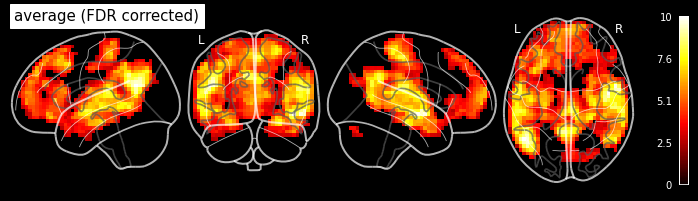

In [199]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0001/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='average (FDR corrected)')

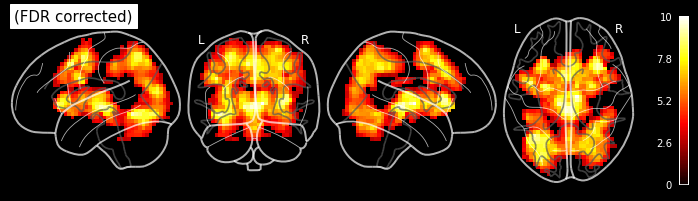

In [203]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0002/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='(FDR corrected)')

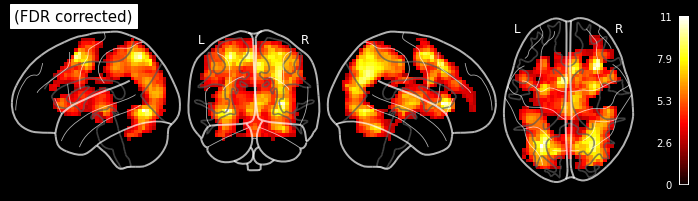

In [204]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0003/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='(FDR corrected)')

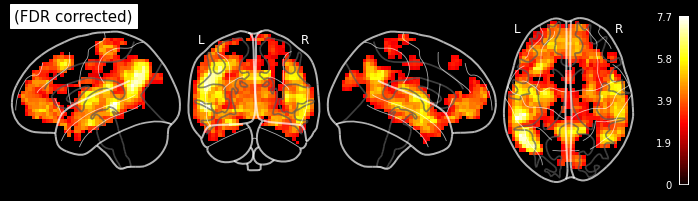

In [205]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0004/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='(FDR corrected)')

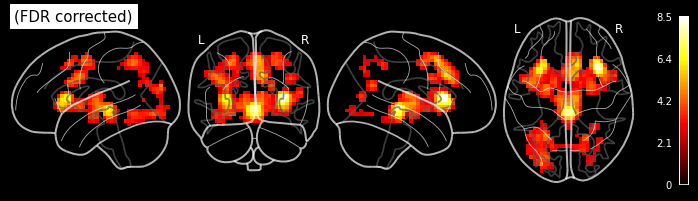

In [206]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0005/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='(FDR corrected)')

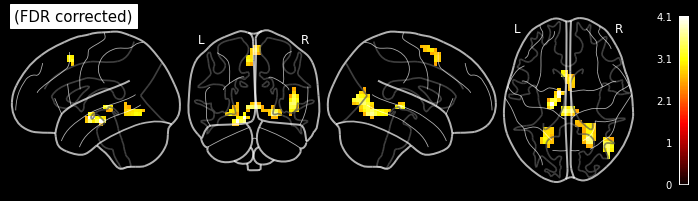

In [207]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0006/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='(FDR corrected)')

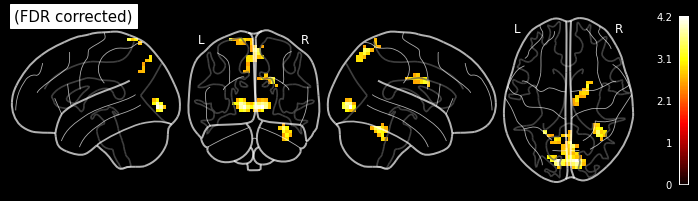

In [208]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0007/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='(FDR corrected)')

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


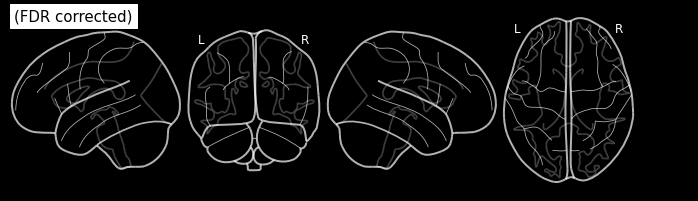

In [209]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0008/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='(FDR corrected)')

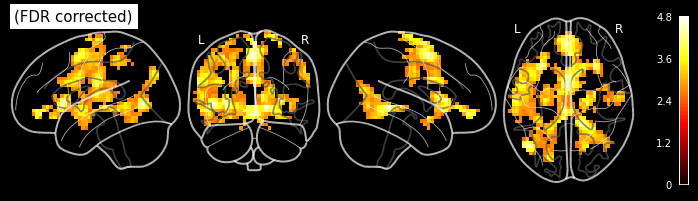

In [210]:
plot_glass_brain('/home/neuro/Result/Visual_search_task/2nd_analysis/analysis_result/datasink/threshold/' + '_cont_id_0009/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='(FDR corrected)')